<a href="https://colab.research.google.com/github/MekdiYilma/HumanitarianCrisisPrediction/blob/main/notebooks/EDA_crisis_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.dates as mdates



In [31]:
yemen_df = pd.read_pickle('../data/yemen_batch1.pkl')
yemen_df.iloc[:2]

,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,...,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_ADM2Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
0,993737639,20210707,202107,2021,2021.5123,USA,UNITED STATES,USA,None,None,...,1,Yemen,YM,YM,None,15.5,47.5,YM,20210707030000,https://foreignaffairs.co.nz/2021/07/07/mil-os...
1,993737872,20210707,202107,2021,2021.5123,YEM,YEMEN,YEM,None,None,...,1,Yemen,YM,YM,None,15.5,47.5,YM,20210707030000,https://foreignaffairs.co.nz/2021/07/07/mil-os...


In [32]:
yemen_df.columns

Index(['GLOBALEVENTID', 'SQLDATE', 'MonthYear', 'Year', 'FractionDate',
       'Actor1Code', 'Actor1Name', 'Actor1CountryCode', 'Actor1KnownGroupCode',
       'Actor1EthnicCode', 'Actor1Religion1Code', 'Actor1Religion2Code',
       'Actor1Type1Code', 'Actor1Type2Code', 'Actor1Type3Code', 'Actor2Code',
       'Actor2Name', 'Actor2CountryCode', 'Actor2KnownGroupCode',
       'Actor2EthnicCode', 'Actor2Religion1Code', 'Actor2Religion2Code',
       'Actor2Type1Code', 'Actor2Type2Code', 'Actor2Type3Code', 'IsRootEvent',
       'EventCode', 'EventBaseCode', 'EventRootCode', 'QuadClass',
       'GoldsteinScale', 'NumMentions', 'NumSources', 'NumArticles', 'AvgTone',
       'Actor1Geo_Type', 'Actor1Geo_FullName', 'Actor1Geo_CountryCode',
       'Actor1Geo_ADM1Code', 'Actor1Geo_ADM2Code', 'Actor1Geo_Lat',
       'Actor1Geo_Long', 'Actor1Geo_FeatureID', 'Actor2Geo_Type',
       'Actor2Geo_FullName', 'Actor2Geo_CountryCode', 'Actor2Geo_ADM1Code',
       'Actor2Geo_ADM2Code', 'Actor2Geo_Lat', 'Act

In [92]:
features = ['SQLDATE', 'Actor1Code', 'Actor1Name', 'Actor1CountryCode', 
       'Actor1KnownGroupCode', 'Actor1EthnicCode', 'Actor1Religion1Code', 
       'Actor1Type1Code',  'Actor2Code',
       'Actor2Name', 'Actor2CountryCode', 'Actor2KnownGroupCode',
       'Actor2EthnicCode', 'Actor2Religion1Code', 
       'Actor2Type1Code',  'IsRootEvent',
       'EventCode',  'QuadClass',
       'GoldsteinScale', 'NumMentions', 'NumSources', 'NumArticles', 'AvgTone',
       'Actor1Geo_Type', 'Actor1Geo_CountryCode',
       'Actor1Geo_ADM1Code',   'Actor2Geo_Type',
       'Actor2Geo_CountryCode', 'Actor2Geo_ADM1Code',
        'ActionGeo_Type', 
       'ActionGeo_CountryCode', 'ActionGeo_ADM1Code', 
        'DATEADDED']

In [34]:
len(yemen_df.columns), len(features)

(61, 36)

In [35]:
yemen_df.loc[:,['EventCode', 'EventBaseCode', 'EventRootCode']]

,EventCode,EventBaseCode,EventRootCode
0,030,030,03
1,020,020,02
2,0874,087,08
3,051,051,05
4,042,042,04
...,...,...,...
19995,160,160,16
19996,190,190,19
19997,030,030,03
19998,190,190,19


In [36]:
event_code_lookup = pd.read_csv('../data/event_code_lookup.csv',header=None, names=['Event'])
event_code_lookup.head()

,Event
0,01 MAKE PUBLIC STATEMENT
1,"010 Make statement, not specified below"
2,011 Decline comment
3,012 Make pessimistic comment
4,013 Make optimistic comment


In [37]:
event_code_lookup.iloc[52,:][0].split(' ', 1)[1][4:]

'Express intent to institute political reform, not specified below'

In [38]:
event_code_lookup['EventCode'] = event_code_lookup.Event.str.split(' ', n=1, expand=True)[0]
event_code_lookup['EventName'] = event_code_lookup.Event.str.split(' ', n=1, expand=True)[1].str.slice(start=4)

In [39]:
event_code_lookup.head()

,Event,EventCode,EventName
0,01 MAKE PUBLIC STATEMENT,01,MAKE PUBLIC STATEMENT
1,"010 Make statement, not specified below",010,"Make statement, not specified below"
2,011 Decline comment,011,Decline comment
3,012 Make pessimistic comment,012,Make pessimistic comment
4,013 Make optimistic comment,013,Make optimistic comment


In [40]:
event_code_lookup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Event      310 non-null    object
 1   EventCode  310 non-null    object
 2   EventName  310 non-null    object
dtypes: object(3)
memory usage: 7.4+ KB


In [93]:
yemen = yemen_df[features]
yemen

,SQLDATE,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,Actor1Religion1Code,Actor1Type1Code,Actor2Code,Actor2Name,...,Actor1Geo_Type,Actor1Geo_CountryCode,Actor1Geo_ADM1Code,Actor2Geo_Type,Actor2Geo_CountryCode,Actor2Geo_ADM1Code,ActionGeo_Type,ActionGeo_CountryCode,ActionGeo_ADM1Code,DATEADDED
0,20210707,USA,UNITED STATES,USA,None,None,None,None,None,None,...,1,YM,YM,0,None,None,1,YM,YM,20210707030000
1,20210707,YEM,YEMEN,YEM,None,None,None,None,None,None,...,1,YM,YM,0,None,None,1,YM,YM,20210707030000
2,20210707,GOV,MINIST,None,None,None,None,GOV,None,None,...,1,YM,YM,0,None,None,1,YM,YM,20210707024500
3,20210707,LEG,GENERAL ASSEMBLY,None,None,None,None,LEG,None,None,...,1,YM,YM,0,None,None,1,YM,YM,20210707024500
4,20210707,CVL,RESIDENTS,None,None,None,None,CVL,YEM,YEMEN,...,1,YM,YM,1,YM,YM,1,YM,YM,20210707030000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,20200821,REF,REFUGEE,None,None,None,None,REF,YEM,YEMEN,...,4,IN,IN28,1,YM,YM,1,YM,YM,20200821131500
19996,20200821,YEM,YEMENI,YEM,None,None,None,None,None,None,...,4,IR,IR00,0,None,None,1,YM,YM,20200821023000
19997,20200822,IRN,IRANIAN,IRN,None,None,None,None,None,None,...,4,IR,IR00,0,None,None,1,YM,YM,20200822171500
19998,20200822,YEM,YEMENI,YEM,None,None,None,None,None,None,...,4,IR,IR00,0,None,None,1,YM,YM,20200822171500


In [94]:
yemen.SQLDATE = pd.to_datetime(yemen.SQLDATE, format='%Y%m%d', errors='ignore')
yemen.DATEADDED = pd.to_datetime(yemen.DATEADDED,  format='%Y%m%d%H%M%S', errors='ignore')

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [95]:
yemen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   SQLDATE                20000 non-null  datetime64[ns]
 1   Actor1Code             18217 non-null  object        
 2   Actor1Name             18217 non-null  object        
 3   Actor1CountryCode      10795 non-null  object        
 4   Actor1KnownGroupCode   893 non-null    object        
 5   Actor1EthnicCode       37 non-null     object        
 6   Actor1Religion1Code    341 non-null    object        
 7   Actor1Type1Code        9105 non-null   object        
 8   Actor2Code             14718 non-null  object        
 9   Actor2Name             14718 non-null  object        
 10  Actor2CountryCode      9277 non-null   object        
 11  Actor2KnownGroupCode   511 non-null    object        
 12  Actor2EthnicCode       32 non-null     object        
 13  A

In [96]:
humanitarian_crisis_events = ['0233', '0243', '0333', '0343', '0243', '073', '074', '0833', '0861', '0863',
                              '092', '094', '103', '1033', '1043', '1122', '1124', '1233', '137', '138', 
                              '1382', '1383', '1384', '1385', '1413', '1423', '1451', '1452', '1453', '1454', 
                              '175', '18', '180', '181', '182', '1821', '1822', '1823', '183', '1831', '1832', 
                              '1833', '184']
yemen.EventCode.isin(humanitarian_crisis_events).value_counts()

False    19152
True       848
Name: EventCode, dtype: int64

In [97]:
yemen['IsHumanitarianCrisis'] = yemen.EventCode.isin(humanitarian_crisis_events)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [98]:
yemen_ts = yemen.set_index('SQLDATE')
yemen_ts = yemen_ts.sort_index(axis = 0)
yemen_ts[yemen_ts.index > '2016-09-15']

,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,Actor1Religion1Code,Actor1Type1Code,Actor2Code,Actor2Name,Actor2CountryCode,...,Actor1Geo_CountryCode,Actor1Geo_ADM1Code,Actor2Geo_Type,Actor2Geo_CountryCode,Actor2Geo_ADM1Code,ActionGeo_Type,ActionGeo_CountryCode,ActionGeo_ADM1Code,DATEADDED,IsHumanitarianCrisis
SQLDATE,,,,,,,,,,,,,,,,,,,,,
2016-09-16,YEM,YEMENI,YEM,None,None,None,None,MOS,ISLAMIC,None,...,YM,YM,1,YM,YM,1,YM,YM,2017-09-16 16:00:00,False
2016-09-16,YEM,YEMENI,YEM,None,None,None,None,MOS,ISLAMIC,None,...,YM,YM,1,YM,YM,1,YM,YM,2017-09-16 16:00:00,True
2016-09-16,YEMGOV,YEMENI,YEM,None,None,None,GOV,MOS,ISLAMIC,None,...,YM,YM,1,YM,YM,1,YM,YM,2017-09-16 16:00:00,False
2016-09-16,YEMGOV,YEMENI,YEM,None,None,None,GOV,MOS,ISLAMIC,None,...,YM,YM,1,YM,YM,1,YM,YM,2017-09-16 16:00:00,True
2016-09-16,YEM,YEMENI,YEM,None,None,None,None,YEMGOV,YEMEN,YEM,...,YM,YM,1,YM,YM,1,YM,YM,2017-09-16 16:45:00,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-07,YEM,YEMEN,YEM,None,None,None,None,SAU,SAUDI ARABIA,SAU,...,YM,YM,1,SA,SA,1,YM,YM,2021-07-07 00:30:00,False
2021-07-07,YEM,YEMENI,YEM,None,None,None,None,SAU,SAUDI ARABIA,SAU,...,YM,YM14,1,SA,SA,4,YM,YM14,2021-07-07 00:30:00,False
2021-07-07,YEMUAF,YEMENI,YEM,None,None,None,UAF,SAU,SAUDI,SAU,...,YM,YM14,1,SA,SA,4,YM,YM14,2021-07-07 00:30:00,False


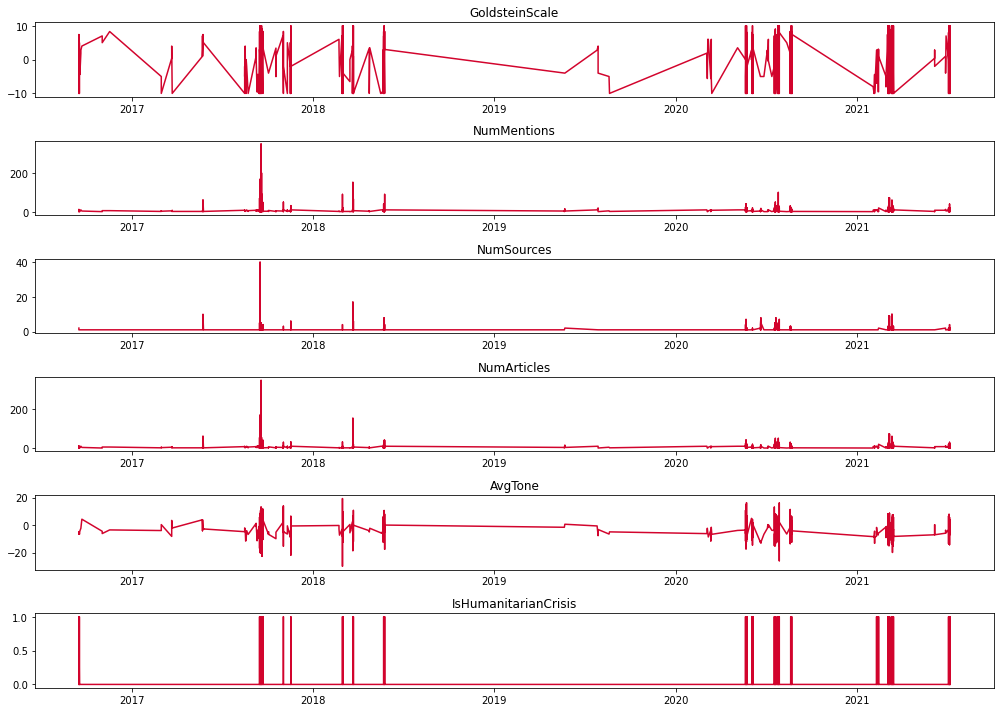

In [171]:
Num_features = ['GoldsteinScale', 'NumMentions', 'NumSources', 'NumArticles', 'AvgTone', 'IsHumanitarianCrisis']

fig, ax = plt.subplots(len(Num_features), figsize=(14, 10), tight_layout=True)

for idx, col in enumerate(Num_features):
    ax[idx].plot(yemen_ts[yemen_ts.index > '2016-09-15'].index, yemen_ts[yemen_ts.index > '2016-09-15'][col], 
                 color = '#D2042D')
    ax[idx].set_title(col);

In [121]:
yemen_ts[['NumMentions', 'NumSources','NumArticles']].tail(20)

,NumMentions,NumSources,NumArticles
SQLDATE,,,
2021-07-07,2,1,2
2021-07-07,20,2,20
2021-07-07,8,1,8
2021-07-07,6,1,6
2021-07-07,6,1,6
2021-07-07,10,1,10
2021-07-07,7,1,7
2021-07-07,10,1,10
2021-07-07,10,1,10


In [105]:
(yemen_ts['NumMentions'] -  yemen_ts['NumArticles']).value_counts()

0      19308
10       205
2        109
4         75
8         63
6         53
1         36
20        35
30        16
3         13
12        13
5         11
16        10
40         8
7          6
80         6
18         5
70         5
28         4
56         3
50         3
24         2
14         2
160        1
38         1
25         1
32         1
90         1
68         1
52         1
60         1
48         1
dtype: int64

In [113]:
yemen_df0 = pd.read_pickle('../data/yemen_batch0.pkl')
yemen_df0 = yemen_df0[features]

yemen_df0.SQLDATE = pd.to_datetime(yemen_df0.SQLDATE, format='%Y%m%d', errors='ignore')
yemen_df0.DATEADDED = pd.to_datetime(yemen_df0.DATEADDED,  format='%Y%m%d%H%M%S', errors='ignore')

yemen_df0['IsHumanitarianCrisis'] = yemen_df0.EventCode.isin(humanitarian_crisis_events)

yemen_df0 = yemen_df0.set_index('SQLDATE')
yemen_df0 = yemen_df0.sort_index(axis = 0)

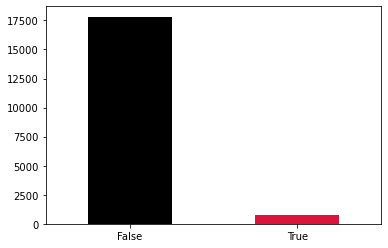

In [293]:
prob  = yemen_df0[yemen_df0.index > '2001-01-01'].IsHumanitarianCrisis.value_counts()
prob.plot(kind='bar', color=['black', '#DC143C'])
plt.xticks(rotation=0)
plt.show()

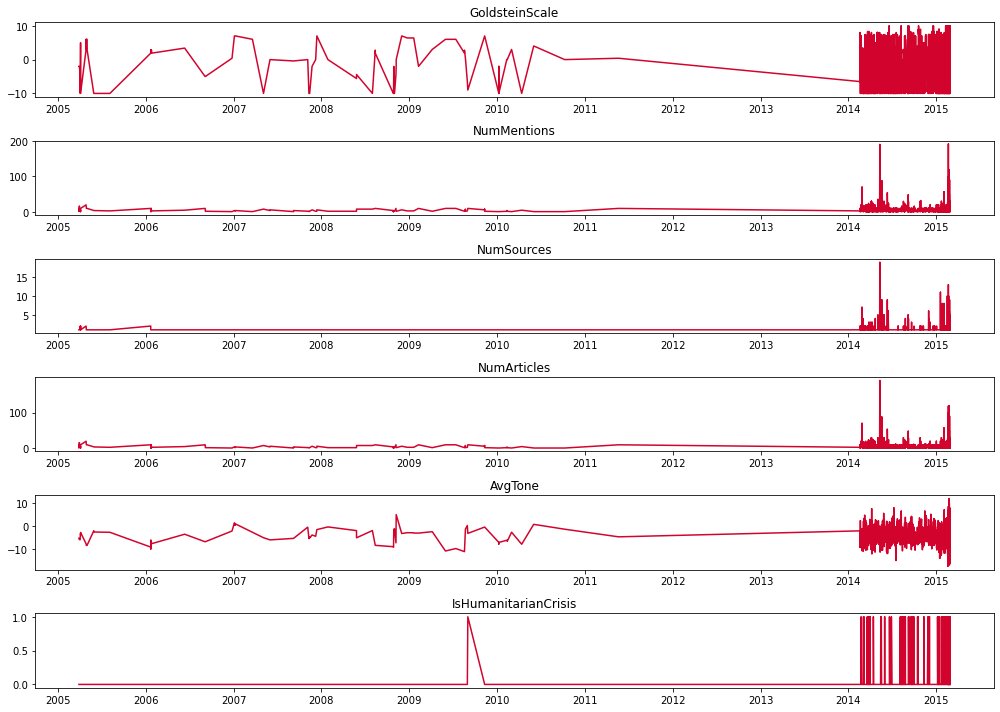

In [178]:
fig, ax = plt.subplots(len(Num_features), figsize=(14, 10), tight_layout=True)

for idx, col in enumerate(Num_features):
    ax[idx].plot(yemen_df0[yemen_df0.index > '2001-01-01'].index, yemen_df0[yemen_df0.index > '2001-01-01'][col],
                color='#D2042D')
    ax[idx].set_title(col);

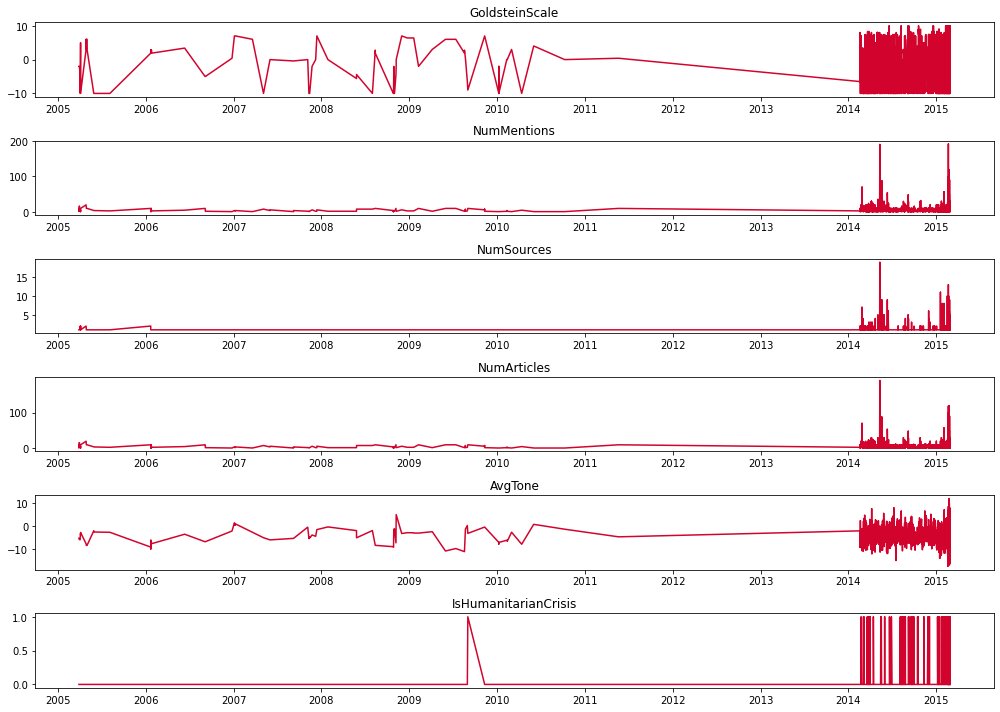

In [191]:
fig, ax = plt.subplots(len(Num_features), figsize=(14, 10), tight_layout=True)

for idx, col in enumerate(Num_features):
    ax[idx].plot(yemen_df0[yemen_df0.index > '2001-01-01'].index, yemen_df0[yemen_df0.index > '2001-01-01'][col],
                color='#D2042D')
    ax[idx].set_title(col);

In [125]:
features_selected = ['Actor1Name', 'Actor2Name', 'QuadClass',
       'GoldsteinScale',  'NumArticles', 'AvgTone',  'IsHumanitarianCrisis']

In [156]:
yemen_df0_selected = yemen_df0[features_selected]
yemen_df0_selected

,Actor1Name,Actor2Name,QuadClass,GoldsteinScale,NumArticles,AvgTone,IsHumanitarianCrisis
SQLDATE,,,,,,,
1920-01-01,SANAA,None,1,0.0,6,-4.464286,False
1920-01-01,YEMENI,TURKISH,4,-10.0,10,-0.320513,False
1920-01-01,None,SCHOLAR,1,1.9,10,-0.164204,False
1920-01-01,SAUDI ARABIA,YEMEN,2,7.0,2,-3.780069,False
1920-01-01,YEMEN,GOVERNMENT,3,-2.0,3,-4.422822,False
...,...,...,...,...,...,...,...
2015-02-28,YEMEN,PROTESTER,4,-5.0,4,0.397812,False
2015-02-28,YEMEN,YEMENI,1,7.0,4,-2.431611,False
2015-02-28,ADEN,None,1,3.5,10,2.054795,False


In [152]:
yemen_df0['IsHumanitarianCrisis'].groupby([yemen_df0.index]).agg(['sum','count','mean']).iloc[20:40]

,sum,count,mean
SQLDATE,,,
2006-01-24,0,2,0.0
2006-06-11,0,2,0.0
2006-09-04,0,1,0.0
2006-09-05,0,2,0.0
2006-12-25,0,1,0.0
2007-01-04,0,1,0.0
2007-01-07,0,1,0.0
2007-01-08,0,1,0.0
2007-03-20,0,1,0.0


In [158]:
yemen_df0_grouped = yemen_df0['IsHumanitarianCrisis'].groupby(pd.Grouper(freq='d')).agg(['sum','count','mean'])
yemen_df0_grouped

,sum,count,mean
SQLDATE,,,
1920-01-01,26,338,0.076923
1920-01-02,16,288,0.055556
1920-01-03,20,373,0.053619
1920-01-04,16,278,0.057554
1920-01-05,6,150,0.040000
...,...,...,...
2015-02-24,123,1975,0.062278
2015-02-25,100,2158,0.046339
2015-02-26,67,1786,0.037514


In [161]:
yemen_df0_selected = yemen_df0_selected.merge(yemen_df0_grouped, how='left', left_index=True , 
                         right_index=True)
yemen_df0_selected

,Actor1Name,Actor2Name,QuadClass,GoldsteinScale,NumArticles,AvgTone,IsHumanitarianCrisis,sum,count,mean
SQLDATE,,,,,,,,,,
1920-01-01,SANAA,None,1,0.0,6,-4.464286,False,26,338,0.076923
1920-01-01,YEMENI,TURKISH,4,-10.0,10,-0.320513,False,26,338,0.076923
1920-01-01,None,SCHOLAR,1,1.9,10,-0.164204,False,26,338,0.076923
1920-01-01,SAUDI ARABIA,YEMEN,2,7.0,2,-3.780069,False,26,338,0.076923
1920-01-01,YEMEN,GOVERNMENT,3,-2.0,3,-4.422822,False,26,338,0.076923
...,...,...,...,...,...,...,...,...,...,...
2015-02-28,YEMEN,PROTESTER,4,-5.0,4,0.397812,False,12,399,0.030075
2015-02-28,YEMEN,YEMENI,1,7.0,4,-2.431611,False,12,399,0.030075
2015-02-28,ADEN,None,1,3.5,10,2.054795,False,12,399,0.030075


''

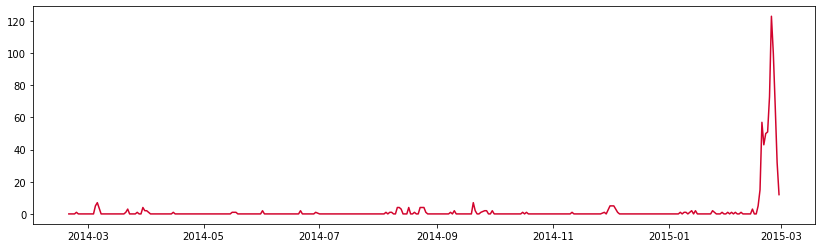

In [192]:
fig, ax = plt.subplots(1, figsize=(14, 4))

ax.plot(yemen_df0_selected[yemen_df0_selected.index > '2014-01-01'].index, 
        yemen_df0_selected[yemen_df0_selected.index > '2014-01-01']['sum'],
       color ='#D2042D')
;

''

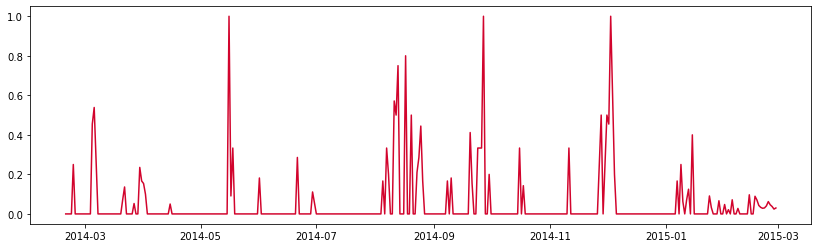

In [181]:
fig, ax = plt.subplots(1, figsize=(14, 4))

ax.plot(yemen_df0_selected[yemen_df0_selected.index > '2014-01-01'].index, 
        yemen_df0_selected[yemen_df0_selected.index > '2014-01-01']['mean'],
       color ='#D2042D')
;

In [188]:
for idx, (train_idx, test_idx) in enumerate(ts_split.split(yemen_df0_selected)):
    print(train_idx, test_idx)

[   0    1    2 ... 3997 3998 3999] [4000 4001 4002 ... 7997 7998 7999]
[   0    1    2 ... 7997 7998 7999] [ 8000  8001  8002 ... 11997 11998 11999]
[    0     1     2 ... 11997 11998 11999] [12000 12001 12002 ... 15997 15998 15999]
[    0     1     2 ... 15997 15998 15999] [16000 16001 16002 ... 19997 19998 19999]


''

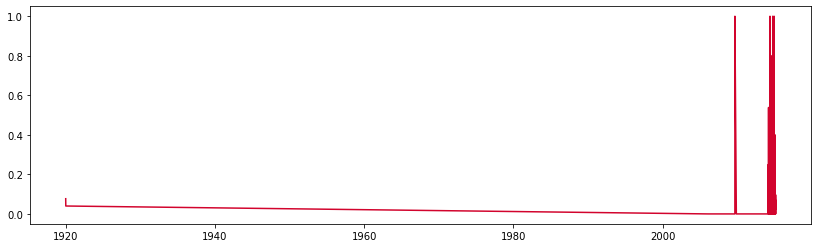

In [194]:
fig, ax = plt.subplots(1, figsize=(14, 4))

ax.plot(yemen_df0_selected.index, 
        yemen_df0_selected['mean'],
       color ='#D2042D')
;

3456

In [242]:
yemen_df0_trimmed

,Actor1Name,Actor2Name,QuadClass,GoldsteinScale,NumArticles,AvgTone,IsHumanitarianCrisis,sum,count,mean
SQLDATE,,,,,,,,,,
2014-02-19,ADEN,BRITAIN,3,-6.5,3,-2.103250,False,0,9,0.000000
2014-02-19,YEMENI,LIBYA,1,1.9,2,-6.102747,False,0,9,0.000000
2014-02-19,LIBYA,YEMENI,1,2.8,2,-6.102747,False,0,9,0.000000
2014-02-19,YEMENI,LIBYA,1,1.9,1,-6.243603,False,0,9,0.000000
2014-02-19,None,ARMY,1,8.0,10,-2.422907,False,0,9,0.000000
...,...,...,...,...,...,...,...,...,...,...
2015-02-28,YEMEN,PROTESTER,4,-5.0,4,0.397812,False,12,399,0.030075
2015-02-28,YEMEN,YEMENI,1,7.0,4,-2.431611,False,12,399,0.030075
2015-02-28,ADEN,None,1,3.5,10,2.054795,False,12,399,0.030075


3687 3687
7374 3687
11061 3687
14748 3687


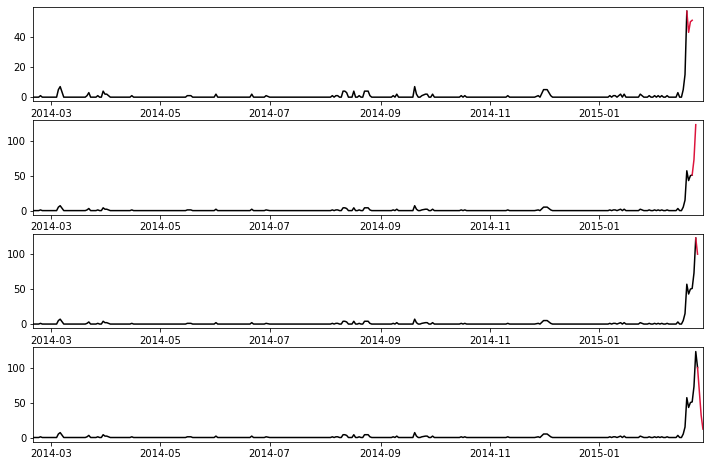

In [270]:
yemen_df0_trimmed = yemen_df0_selected[yemen_df0_selected.index > '2014-01-01']

ts_split = TimeSeriesSplit(4)


fig, ax = plt.subplots(4, figsize = (12,8))

for idx, (train_idx, test_idx) in enumerate(ts_split.split(yemen_df0_trimmed)):
    print(len(yemen_df0_trimmed.iloc[train_idx].index), len(yemen_df0_trimmed.iloc[test_idx]['sum']))
    ax[idx].plot(yemen_df0_trimmed.iloc[train_idx].index, yemen_df0_trimmed.iloc[train_idx]['sum'].values, color='black')
    ax[idx].plot(yemen_df0_trimmed.iloc[test_idx].index, yemen_df0_trimmed.iloc[test_idx]['sum'].values, color='#DC143C')
        
    ax[idx].set_xlim(yemen_df0_trimmed.index.min(), yemen_df0_trimmed.index.max())


3687 3687
7374 3687
11061 3687
14748 3687


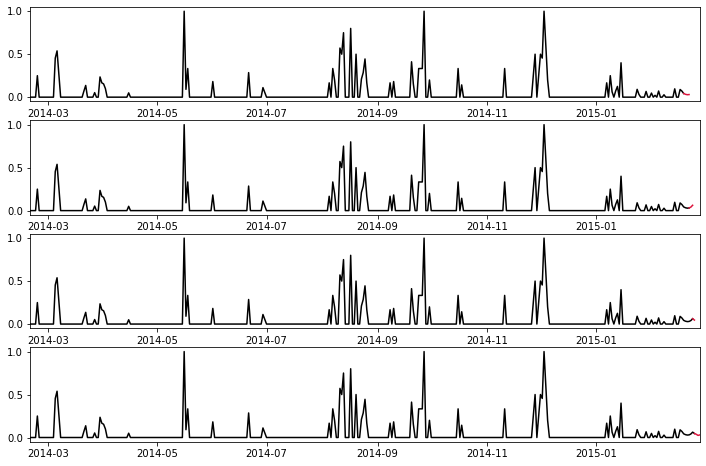

In [267]:
yemen_df0_trimmed = yemen_df0_selected[yemen_df0_selected.index > '2014-01-01']

ts_split = TimeSeriesSplit(4)


fig, ax = plt.subplots(4, figsize = (12,8))

for idx, (train_idx, test_idx) in enumerate(ts_split.split(yemen_df0_trimmed)):
    print(len(yemen_df0_trimmed.iloc[train_idx].index), len(yemen_df0_trimmed.iloc[test_idx]['mean']))
    ax[idx].plot(yemen_df0_trimmed.iloc[train_idx].index, yemen_df0_trimmed.iloc[train_idx]['mean'].values, color='black')
    ax[idx].plot(yemen_df0_trimmed.iloc[test_idx].index, yemen_df0_trimmed.iloc[test_idx]['mean'].values, color='#DC143C')
        
    ax[idx].set_xlim(yemen_df0_trimmed.index.min(), yemen_df0_trimmed.index.max())

In [273]:
yemen_df0_trimmed.to_csv('../data/yemen_batch0.csv')

In [277]:
yemen_df0_grouped

,sum,count,mean
SQLDATE,,,
1920-01-01,26,338,0.076923
1920-01-02,16,288,0.055556
1920-01-03,20,373,0.053619
1920-01-04,16,278,0.057554
1920-01-05,6,150,0.040000
...,...,...,...
2015-02-24,123,1975,0.062278
2015-02-25,100,2158,0.046339
2015-02-26,67,1786,0.037514


''

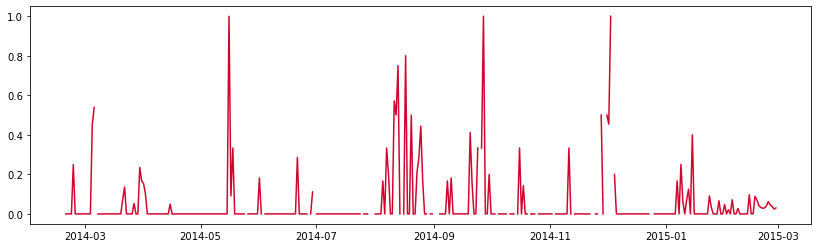

In [278]:
fig, ax = plt.subplots(1, figsize=(14, 4))

ax.plot(yemen_df0_grouped[yemen_df0_grouped.index > '2014-01-01'].index, 
        yemen_df0_grouped[yemen_df0_grouped.index > '2014-01-01']['mean'],
       color ='#D2042D')
;

In [288]:
yemen_df0_grouped2 = yemen_df0['IsHumanitarianCrisis'].groupby(yemen_df0.index).agg(['sum','count','mean'])
yemen_df0_grouped2

,sum,count,mean
SQLDATE,,,
1920-01-01,26,338,0.076923
1920-01-02,16,288,0.055556
1920-01-03,20,373,0.053619
1920-01-04,16,278,0.057554
1920-01-05,6,150,0.040000
...,...,...,...
2015-02-24,123,1975,0.062278
2015-02-25,100,2158,0.046339
2015-02-26,67,1786,0.037514


In [291]:
yemen_df0_grouped2[yemen_df0_grouped2.index > '2014-01-01'].shape

(346, 3)

''

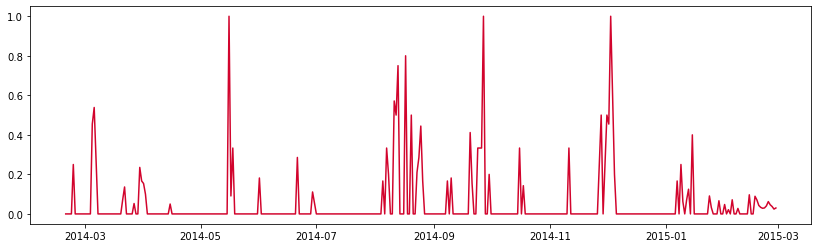

In [292]:
fig, ax = plt.subplots(1, figsize=(14, 4))

ax.plot(yemen_df0_grouped2[yemen_df0_grouped2.index > '2014-01-01'].index, 
        yemen_df0_grouped2[yemen_df0_grouped2.index > '2014-01-01']['mean'],
       color ='#D2042D')
;

# Appendix

In [45]:
d = {'col1': [1, 2,3,4], 'col2': ['03', '030','3','4']}
df = pd.DataFrame(data=d)
df

,col1,col2
0,1,03
1,2,030
2,3,3
3,4,4


In [46]:
value_list = ['03','3']
df.col2.isin(value_list)

0     True
1    False
2     True
3    False
Name: col2, dtype: bool

In [272]:
import pandas as pd
pd.__version__

'1.2.3'

In [275]:
filename = 'yemen_batch0'
pd.read_csv(f'../data/{filename}.csv', index_col=0)

,Actor1Name,Actor2Name,QuadClass,GoldsteinScale,NumArticles,AvgTone,IsHumanitarianCrisis,sum,count,mean
SQLDATE,,,,,,,,,,
2014-02-19,ADEN,BRITAIN,3,-6.5,3,-2.103250,False,0,9,0.000000
2014-02-19,YEMENI,LIBYA,1,1.9,2,-6.102747,False,0,9,0.000000
2014-02-19,LIBYA,YEMENI,1,2.8,2,-6.102747,False,0,9,0.000000
2014-02-19,YEMENI,LIBYA,1,1.9,1,-6.243603,False,0,9,0.000000
2014-02-19,NaN,ARMY,1,8.0,10,-2.422907,False,0,9,0.000000
...,...,...,...,...,...,...,...,...,...,...
2015-02-28,YEMEN,PROTESTER,4,-5.0,4,0.397812,False,12,399,0.030075
2015-02-28,YEMEN,YEMENI,1,7.0,4,-2.431611,False,12,399,0.030075
2015-02-28,ADEN,NaN,1,3.5,10,2.054795,False,12,399,0.030075
